# 1. Gather data required for the analysis 

In [1]:
import requests
CLIENT_ID = "O4PFHUAQBCNEOAYFSMBDVOUOO2EA3BIZNLH2CTZ4LTE5YJYI"
CLIENT_SECRET = "VH2BSYPSXUM3N0B5ZGNCHTGNU4I3L12A1PRRHJIVWTIUIJAR"
VERSION = '20180605'

# define query 1 function to get nearby venues for a borough/langitude+longitude
def getNearbyVenues(names, latitudes, longitudes, radius=750):
    
    venues_list = []
    # dictionary containing the details for a venue id
    venues_details = {}
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        # limit output to venues that have food
        # &section=food
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        try:
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name'],
                v['venue']['id']) for v in results])
        
            # if this venue is clearly a restaurant, get its details
            for v in results:
                if("Restaurant" in v['venue']['categories'][0]['name']):
                    venues_details[v['venue']['id']] = getRestaurantDetails(v['venue']['id'])
        except:
            print("error for " + str(name))
            
                

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category',
                  'Venue ID']
    
    return([nearby_venues, venues_details])

# define query 2 function to get the details for a restaurant
def getRestaurantDetails(venueId):
        # create the API request URL
        # limit output to venues that have food
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venueId,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        # make the GET request
        return requests.get(url).json()["response"]

In [2]:
# define dataset 1/2 containing the location of neighborhoods for postal codes
import pandas as pd
tn = pd.read_csv("toronto_neighborhood_data.csv")[['PostalCode','Borough','Neighborhood','Latitude','Longitude']]

In [3]:
tn.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Harbourfront,Regent Park",43.654260,-79.360636
3,M6A,North York,"Lawrence Heights,Lawrence Manor",43.718518,-79.464763
4,M7A,Queen's Park,Queen's Park,43.662301,-79.389494


In [4]:
# Get all venues/restaurants for a neighborhood or reload this data via pickle if already done
import pickle 
try:
    fh_results = open('results_list_all.obj', 'rb')
    results_list = pickle.load(fh_results)
except:
    names = list(tn['PostalCode'])
    latitudes = list(tn['Latitude'])
    longitudes = list(tn['Longitude'])
    results_list = getNearbyVenues(names, latitudes, longitudes)
    # save object to file
    fh_results = open('results_list_all.obj', 'wb')
    pickle.dump(results_list, fh_results)
fh_results.close()

# 2. Format data

In [5]:
import numpy as np
venues_onehot = pd.get_dummies(results_list[0][['Venue Category']], prefix="", prefix_sep="")
venues_onehot['Neighborhood'] = results_list[0]['Neighborhood'] 
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]
toronto_venues_onehot = venues_onehot.groupby('Neighborhood').sum()
toronto_venues_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
Neighborhood,,,,,,,,,,,,,,,,,,,,,
M1B,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1C,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1E,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1G,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
M1H,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
# format xData
xData = 0
xRows = []
xi = 0
for index, row in toronto_venues_onehot.iterrows():
    xRows.append(row)
    xData = pd.DataFrame(xRows, columns=toronto_venues_onehot.columns).reset_index()

# remove index from xData
xData = xData.drop(columns='index')
xData.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint,Women's Store
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [7]:
restaurants_per_neighborhood = {}
for i,venueId in enumerate(results_list[0]['Venue ID']):
    Nhood = results_list[0]['Neighborhood'][i]
    if(not Nhood in restaurants_per_neighborhood):
        restaurants_per_neighborhood[Nhood] = []
    try:
        restaurants_per_neighborhood[Nhood].append(results_list[1][venueId]['venue'])
    except:
        continue

# define restaurant categories (those that are interesting for the stakeholder)
testCategories = ["Italian Restaurant", "Fast Food Restaurant", "Chinese Restaurant", "Indian Restaurant", "Greek Restaurant", "Japanese Restaurant"]
Averages = {}
Data = {}

for key in testCategories:
    Data[key] = []
    Averages[key] = []
ix = 0

# collect all ratings
for index, row in toronto_venues_onehot.iterrows():
    for testCat in testCategories:
        Data[testCat].append([])
    for restaurant in restaurants_per_neighborhood[index]:
        for testCat in testCategories:
            if(testCat in restaurant['categories'][0]['name']):
                try:
                    Data[testCat][ix].append(restaurant['rating'])
                    Averages[testCat].append(restaurant['rating'])
                except:
                    # skip datasets with no rating
                    continue
    ix += 1

yAverages = {}
yData = {}
# get averages
for key in testCategories:
    yData[key] = []
    yAverages[key] = []

for key, value in Averages.items():
    yAverages[key] = sum(value) / len(value)

# code 1 as better, 0 as worse than average or no data (which I define as worse than average)
for key, value in Data.items():
    yData[key] = []
    for rating in value:
        if(len(rating) > 0):
            average = sum(rating) / len(rating)
        else:
            average = 0
        if(average == 0):
            yData[key].append(0)
        elif (average > yAverages[key]):
            yData[key].append(1)
        else:
            yData[key].append(0)
    
print(yAverages)
print(yData)

{'Italian Restaurant': 7.782978723404255, 'Fast Food Restaurant': 6.121212121212122, 'Chinese Restaurant': 7.2375, 'Indian Restaurant': 7.424999999999998, 'Greek Restaurant': 7.661904761904762, 'Japanese Restaurant': 7.78787878787879}
{'Italian Restaurant': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Fast Food Restaurant': [0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'Chinese Restaurant': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0

# 3. Exploratory data analysis

In [8]:
# build chloropleth maps of the restaurants/neighborhoods in Toronto, including ratings.
import folium

# use location data from wikipedia to create map of toronto
map_toronto = folium.Map(location=[43.741667, -79.373333], zoom_start=12)

restaurant_colormap = {"Italian Restaurant":"red", "Fast Food Restaurant":"gray", "Chinese Restaurant":"yellow", "Indian Restaurant":"brown", "Greek Restaurant":"blue", "Japanese Restaurant":"orange"}

# add markers of neighborhoods/boroughs and ratings
for neighborhood, restaurants in restaurants_per_neighborhood.items():
    for restaurant in restaurants:
        try:
            if(restaurant['categories'][0]['name'] in testCategories):
                label = '{}, {}'.format(restaurant['categories'][0]['name'], restaurant['rating'])
                label = folium.Popup(label, parse_html=True)
                rating = restaurant['rating']
                color=restaurant_colormap[restaurant['categories'][0]['name']]
                folium.Marker(
                    location=[restaurant['location']['lat']+0.004,restaurant['location']['lng']-0.001],
                    icon=folium.DivIcon(html=f"""<div style="color: {color}; font-size:12pt">{rating}</div>""")
                ).add_to(map_toronto)
                folium.CircleMarker(
                    [restaurant['location']['lat'],restaurant['location']['lng']],
                    radius=4,
                    popup=label,
                    color="black",
                    fill=True,
                    fill_color=restaurant_colormap[restaurant['categories'][0]['name']],
                    fill_opacity=0.7,
                    parse_html=False).add_to(map_toronto)
                
        except:
            continue


In [9]:
map_toronto

# 4. Train model using the data

In [10]:
# now that we have x data and y data. Learn model..
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score


trees = {}

# set a seed to get the same result each time
np.random.seed(1)

for category in testCategories:
    print(category)
    #Train Model and Predict average scores of restaurant types
    Tree = DecisionTreeClassifier(criterion="entropy")
    
    
    # 1. Single run to get a feeling for the scores
    print("Single run:")
    X_train, X_test, y_train, y_test = train_test_split(xData, yData[category], test_size=0.2)
    Tree # it shows the default parameters
    trees[category] = Tree.fit(X_train,y_train)
    yhat = Tree.predict(X_test)
    print(*yhat, sep=' ')
    print(*y_test, sep=' ')
    print("Accuracy: " + str(metrics.accuracy_score(y_test, yhat)))
    
    # 2. do cross validation 5-fold to get estimated accuracies
    print("Cross validation:")
    scores = cross_val_score(Tree, xData, yData[category], cv=5)
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print(scores)
    
    print("-----------------")

Italian Restaurant
Single run:
0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 0 0 0
0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 0 1 0 0
Accuracy: 0.9523809523809523
Cross validation:
Accuracy: 0.93 (+/- 0.08)
[0.9047619  1.         0.9047619  0.95       0.89473684]
-----------------
Fast Food Restaurant
Single run:
0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1 0
0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0
Accuracy: 0.8571428571428571
Cross validation:
Accuracy: 0.86 (+/- 0.16)
[0.71428571 0.95238095 0.9        0.9        0.85      ]
-----------------
Chinese Restaurant
Single run:
0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0
Accuracy: 0.8571428571428571
Cross validation:
Accuracy: 0.94 (+/- 0.07)
[0.9047619 0.9047619 1.        0.95      0.95     ]
-----------------
Indian Restaurant
Single run:
0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Accuracy: 0.9523809523809523
Cross validation:
Accuracy: 0.93 (+/- 0.07)
[0.95238095 0.85714286 0.95

# 5. Analyze model
For simplifications, I am concentrating on the Italian restaurant model

In [11]:
# plot all decision tree
import graphviz
from sklearn import tree
graphs = {}
for category in testCategories:
    tree_data = tree.export_graphviz(trees[category], out_file=None) 
    graphs[category] = graphviz.Source(tree_data) 

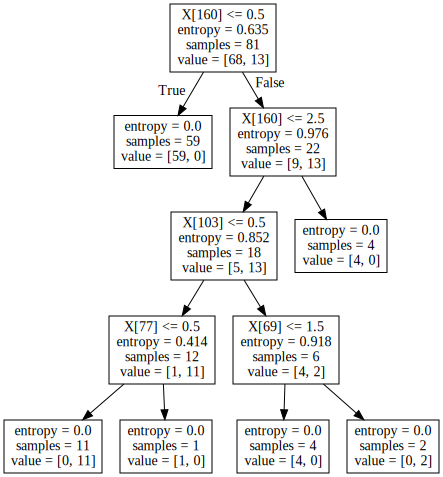

In [12]:
# Analyze graph for Italian Restaurant
graphs["Italian Restaurant"]

In [13]:
# Analyze nodes of decision tree
print(xData.columns[160])
print(xData.columns[103])
print(xData.columns[77])
print(xData.columns[69])

Italian Restaurant
Fast Food Restaurant
Convenience Store
Coffee Shop
